In [2]:
import warnings

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import seaborn as sns

from sklearn.pipeline import Pipeline

from preprocess_sunshine import sunshine_transformer
from preprocess_raintomorrow import raintomorrow_transformer
from preprocess_date import preprocess_date_transformer
from preprocess_temp import preprocess_temp
from preprocess_rainfall_raintoday import rainfall_raintoday_transformer
from preprocess_wind import wind_speed_transformer, wind_dir_transformer
from preprocess_humidity_pressure import VoisinageNAImputer
from preprocess_evaporation import evaporation_transformer
from preprocess_cloud import cloud_transformer



from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import IsotonicRegression

from sklearn.linear_model import LogisticRegression

from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split,  GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, brier_score_loss, roc_curve, roc_auc_score, precision_recall_curve, recall_score, precision_score, log_loss


In [3]:
df = pd.read_csv('../data/weatherAUS.csv')
city = 'Uluru'

df = df[df['Location'].isin([city])]

df.isna().sum()

Date                0
Location            0
MinTemp            35
MaxTemp             7
Rainfall           56
Evaporation      1578
Sunshine         1578
WindGustDir        54
WindGustSpeed      54
WindDir9am         66
WindDir3pm         33
WindSpeed9am       36
WindSpeed3pm       30
Humidity9am        15
Humidity3pm         4
Pressure9am        10
Pressure3pm         4
Cloud9am         1230
Cloud3pm         1161
Temp9am            15
Temp3pm             4
RainToday          56
RainTomorrow       57
dtype: int64

In [4]:

warnings.filterwarnings('ignore')

df = pd.read_csv('../data/weatherAUS.csv')

city = 'Brisbane'

df = df[df['Location'].isin([city])]

# print(df.isna().sum()/len(df))

columns_to_drop = [col for col in df.columns if df[col].isna().mean() > 0.30]

# print('colonne drop', columns_to_drop)
# print('colonne du dataframe', df.columns)

transformers = []

if 'RainTomorrow' not in columns_to_drop:
    transformers.append(('raintomorrow_transformer', raintomorrow_transformer()))

if 'Evaporation' not in columns_to_drop:
    transformers.append(('evaporation_transformer', evaporation_transformer()))
if 'Sunshine' not in columns_to_drop:
    transformers.append(('sunshine_transformer', sunshine_transformer()))

if 'Date' not in columns_to_drop:
    transformers.append(('date_transformer', preprocess_date_transformer()))
for temp_col in ['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm']:
    if temp_col not in columns_to_drop:
        transformers.append((f'{temp_col.lower()}_transformer', preprocess_temp(col_select=temp_col)))
for wind_col in ['WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm']:
    if wind_col not in columns_to_drop:
        transformers.append((f'{wind_col.lower()}_transformer', wind_speed_transformer(col_select=wind_col)))
for wind_dir_col in ['WindGustDir', 'WindDir9am', 'WindDir3pm']:
    if wind_dir_col not in columns_to_drop:
        transformers.append((f'{wind_dir_col.lower()}_transformer', wind_dir_transformer(col_select=wind_dir_col)))
if 'Rainfall' not in columns_to_drop:
    transformers.append(('rainfall_transformer', rainfall_raintoday_transformer(city=city)))
for humidity_col in ['Humidity9am', 'Humidity3pm']:
    if humidity_col not in columns_to_drop:
        transformers.append((f'{humidity_col.lower()}_imputer', VoisinageNAImputer(column=humidity_col)))
for pressure_col in ['Pressure9am', 'Pressure3pm']:
    if pressure_col not in columns_to_drop:
        transformers.append((f'{pressure_col.lower()}_imputer', VoisinageNAImputer(column=pressure_col)))

for cloud_col in ['Cloud9am', 'Cloud3pm']:
    if cloud_col not in columns_to_drop:
        transformers.append((f'{cloud_col.lower()}_transformer', cloud_transformer(col_select=cloud_col)))

df_transformed = Pipeline(transformers).fit_transform(df)

df = df.drop(columns = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'] + columns_to_drop)
df = df.set_index('Date')

print('avant', df.shape)
df.dropna(inplace = True)
print('apres', df.shape)

Pas de station à moins de 50 km de Brisbane
avant (3161, 145)
apres (3118, 145)


In [ ]:
pd.set_option('display.max_rows', None)
df.isna().sum()

In [5]:
X = df.drop(columns='RainTomorrow')
y = df['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

scaler = MinMaxScaler(feature_range=(-1, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

poids = y_train.value_counts(normalize = True)


model = LogisticRegression(verbose = 1,
                           C = 1,
                           max_iter = 1000,
                           penalty = 'l1',
                           solver = 'liblinear',
                           intercept_scaling = 0.1,
                           tol = 0.01
                        )


model.fit(X_train_scaled, y_train)


prob = model.predict_proba(X_test_scaled)
y_pred_prob1 = prob[:, 1]

print(y_test.value_counts(normalize = True))

if y_train.value_counts(normalize=True)[1] < 0.15:
    threshold = 0.165
elif y_train.value_counts(normalize=True)[1] > 0.30:
    threshold = 0.85
else:
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob1)
    diff = abs(precision - recall)
    threshold = thresholds[diff.argmin()]
print(f"Seuil optimal : {threshold}")

y_pred = (y_pred_prob1 > threshold).astype(int)

print('Accuracy score: ', model.score(X_test_scaled, y_test))
print('F1 score: ', f1_score(y_test, y_pred))
print('ROC AUC score: ', roc_auc_score(y_test, y_pred))
print('Brier score: ', brier_score_loss(y_test, y_pred), '\n\n')

print(confusion_matrix(y_test, y_pred), '\n\n')
print(classification_report(y_test, y_pred))

[LibLinear]iter   1  #CD cycles 1
iter   2  #CD cycles 1
iter   3  #CD cycles 1
iter   4  #CD cycles 1
iter   5  #CD cycles 6
iter   6  #CD cycles 1
iter   7  #CD cycles 17
optimization finished, #iter = 7
Objective value = 736.236879
#nonzeros/#features = 80/145
0.0    0.774359
1.0    0.225641
Name: RainTomorrow, dtype: float64
Seuil optimal : 0.37703243062601793
Accuracy score:  0.8551282051282051
F1 score:  0.6837606837606838
ROC AUC score:  0.7953792895845876
Brier score:  0.1423076923076923 


[[549  55]
 [ 56 120]] 


              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91       604
         1.0       0.69      0.68      0.68       176

    accuracy                           0.86       780
   macro avg       0.80      0.80      0.80       780
weighted avg       0.86      0.86      0.86       780



In [ ]:
prob

In [ ]:
print(X_train.isna().sum())

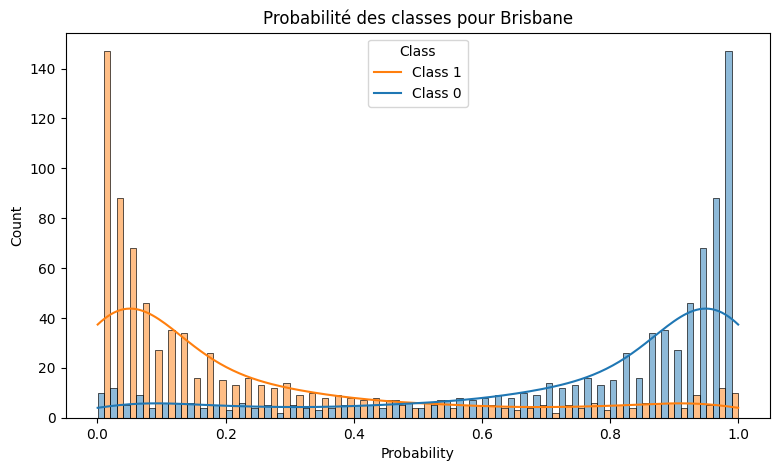

In [7]:
# y_pred_prob = model.predict_proba(X_test_scaled)
# probs_inverted = 1 - probs_scaled
# probs_normalized_1 = probs_inverted / np.max(probs_inverted)


plt.figure(figsize = (20, 5))
plt.subplot(121)
sns.histplot(prob, bins = 50, kde = True,
             stat = 'count', multiple = 'dodge',
             color = ['yellow', 'blue'])
plt.xlabel('Probability')
plt.legend(title='Class', labels=['Class 1', 'Class 0'], loc='upper center')
plt.title(f'Probabilité des classes pour {city}')
plt.show()


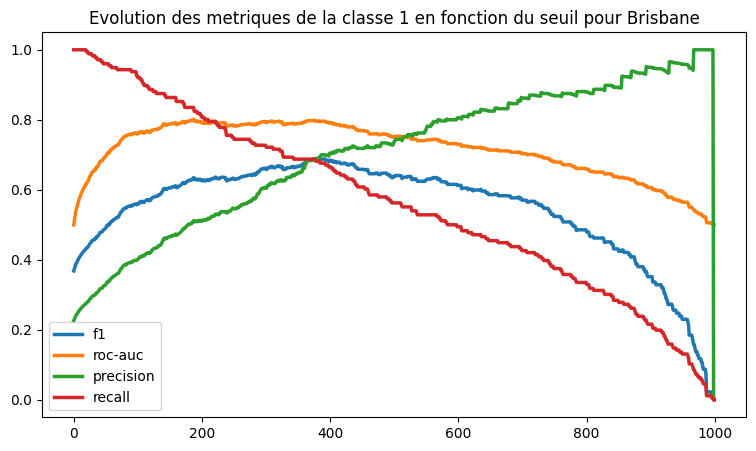

In [15]:
f1_1 = []
roc_1 = []
precision1 = []
recall1 = []

for i in np.linspace(0, 1, 1000):

    seuil = i

    y_pred = (y_pred_prob1 > i).astype("int32")

    f1_1.append(f1_score(y_test, y_pred))
    roc_1.append(roc_auc_score(y_test, y_pred))
    precision1.append(precision_score(y_test, y_pred))
    recall1.append(recall_score(y_test, y_pred))

plt.figure(figsize = (20, 5))

plt.subplot(121)
plt.plot(f1_1, label = 'f1', linewidth=2.5)
plt.plot(roc_1, label = 'roc-auc', linewidth=2.5)
plt.plot(precision1, label = 'precision', linewidth=2.5)
plt.plot(recall1, label = 'recall', linewidth=2.5)
plt.title(f'Evolution des metriques de la classe 1 en fonction du seuil pour {city}')
plt.legend()

plt.show()

In [ ]:
df = pd.read_csv('../data/weatherAUS.csv')


print(df['Location'].unique())

In [17]:

df_1 = pd.read_csv('../data/weatherAUS.csv')

list_city = []
list_accuracy = []
list_f1 = []
list_recall = []
list_precision = []
list_roc = []

# print(df['Location'].unique(), end = '\n\n')

# while True:

#     city = input('Quelle ville choisissez vous ?\n ---->\n\n').capitalize()

#     if city in df['Location'].unique():
#         break  # La ville est valide, on sort de la boucle
#     else:
#         print(f"La ville '{city}' n'est pas dans la liste. \n\n Veuillez choisir une ville parmi celles disponibles.")

city = df_1['Location'].unique()
print(city)
for i in city:
    print('la ville -----------------', i)

    df = df_1[df_1['Location'].isin([i])]

    columns_to_drop = [col for col in df.columns if df[col].isna().mean() > 0.30]

    # print('colonne drop', columns_to_drop)
    # print('colonne du dataframe', df.columns)

    transformers = []
    if 'RainTomorrow' not in columns_to_drop:
        transformers.append(('raintomorrow_transformer', raintomorrow_transformer()))
    if 'Evaporation' not in columns_to_drop:
        transformers.append(('evaporation_transformer', evaporation_transformer()))
    if 'Sunshine' not in columns_to_drop:
        transformers.append(('sunshine_transformer', sunshine_transformer()))
    if 'Date' not in columns_to_drop:
        transformers.append(('date_transformer', preprocess_date_transformer()))
    for temp_col in ['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm']:
        if temp_col not in columns_to_drop:
            transformers.append((f'{temp_col.lower()}_transformer', preprocess_temp(col_select=temp_col)))
    for wind_col in ['WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm']:
        if wind_col not in columns_to_drop:
            transformers.append((f'{wind_col.lower()}_transformer', wind_speed_transformer(col_select=wind_col)))
    for wind_dir_col in ['WindGustDir', 'WindDir9am', 'WindDir3pm']:
        if wind_dir_col not in columns_to_drop:
            transformers.append((f'{wind_dir_col.lower()}_transformer', wind_dir_transformer(col_select=wind_dir_col)))
    if 'Rainfall' not in columns_to_drop:
        transformers.append(('rainfall_transformer', rainfall_raintoday_transformer(city=city)))
    for humidity_col in ['Humidity9am', 'Humidity3pm']:
        if humidity_col not in columns_to_drop:
            transformers.append((f'{humidity_col.lower()}_imputer', VoisinageNAImputer(column=humidity_col)))
    for pressure_col in ['Pressure9am', 'Pressure3pm']:
        if pressure_col not in columns_to_drop:
            transformers.append((f'{pressure_col.lower()}_imputer', VoisinageNAImputer(column=pressure_col)))
    for cloud_col in ['Cloud9am', 'Cloud3pm']:
        if cloud_col not in columns_to_drop:
            transformers.append((f'{cloud_col.lower()}_transformer', cloud_transformer(col_select=cloud_col)))



    df_transformed = Pipeline(transformers).fit_transform(df)

    df = df.drop(columns = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'] + columns_to_drop)
    df = df.set_index('Date')
    print(df.columns)

    df.dropna(inplace = True)


    X = df.drop(columns = 'RainTomorrow')
    y = df['RainTomorrow']

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

    scaler = MinMaxScaler(feature_range = (-1, 1))
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)


    model = LogisticRegression(verbose = 1, C = 1, max_iter = 5000, penalty = 'l1',
                               solver = 'liblinear',
                               intercept_scaling = 0.1, l1_ratio = 0.5, tol = 0.01)


    model.fit(X_train_scaled, y_train)

    print(y_train.value_counts(normalize = True))
    print(y_train.value_counts())

    prob = model.predict_proba(X_test_scaled)

    y_pred_prob1 = model.predict_proba(X_test_scaled)[:, 1]

    if y_train.value_counts(normalize = True)[1] < 0.15:
        threshold = 0.165
    if y_train.value_counts(normalize = True)[1] > 0.30:
        threshold = 0.85
    else:
        precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob1)
        diff = abs(precision - recall)
        threshold = thresholds[diff.argmin()]
    print(threshold)


    y_pred = (y_pred_prob1 > threshold).astype(int)

    list_city.append(i)

    list_accuracy.append(model.score(X_test_scaled, y_test))
    list_f1.append(f1_score(y_test, y_pred))
    list_roc.append(roc_auc_score(y_test, y_pred))
    list_precision.append(precision_score(y_test, y_pred))
    list_recall.append(recall_score(y_test, y_pred))


['Albury' 'BadgerysCreek' 'Cobar' 'CoffsHarbour' 'Moree' 'Newcastle'
 'NorahHead' 'NorfolkIsland' 'Penrith' 'Richmond' 'Sydney' 'SydneyAirport'
 'WaggaWagga' 'Williamtown' 'Wollongong' 'Canberra' 'Tuggeranong'
 'MountGinini' 'Ballarat' 'Bendigo' 'Sale' 'MelbourneAirport' 'Melbourne'
 'Mildura' 'Nhil' 'Portland' 'Watsonia' 'Dartmoor' 'Brisbane' 'Cairns'
 'GoldCoast' 'Townsville' 'Adelaide' 'MountGambier' 'Nuriootpa' 'Woomera'
 'Albany' 'Witchcliffe' 'PearceRAAF' 'PerthAirport' 'Perth' 'SalmonGums'
 'Walpole' 'Hobart' 'Launceston' 'AliceSprings' 'Darwin' 'Katherine'
 'Uluru']
la ville ----------------- Albury
Pas de station à moins de 50 km de Albury
Index(['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am',
       'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
       'Pressure3pm',
       ...
       'WindSpeed3pm_std_3', 'WindSpeed3pm_max_3', 'WindSpeed3pm_min_3',
       'WindSpeed3pm_diff', 'WindGustDir_cos', 'WindGustDir_sin',
       'WindDir9am_cos', 'Win

In [37]:
df_global = pd.DataFrame({
    'location' : list_city,
    'accuracy' : list_accuracy,
    'f1': list_f1,
    'roc-auc' : list_roc,
    'precision' : list_precision,
    'recall' : list_recall}
)

df_global.set_index('location', inplace = True)


df_global.to_excel('../data_saved/first_result_evap.xlsx')

In [25]:
df_global.median(axis = 0)

accuracy     0.857651
f1           0.636605
roc-auc      0.770229
precision    0.666667
recall       0.634921
dtype: float64

In [34]:
df_global

,accuracy,f1,roc-auc,precision,recall
location,,,,,
Albury,0.859249,0.636066,0.770619,0.638158,0.633987
BadgerysCreek,0.879412,0.614232,0.759267,0.616541,0.611940
Cobar,0.906902,0.643275,0.791834,0.647059,0.639535
CoffsHarbour,0.793713,0.322275,0.588827,0.809524,0.201183
Moree,0.909250,0.678788,0.810819,0.682927,0.674699
Newcastle,0.803184,0.530973,0.688890,0.532544,0.529412
NorahHead,0.815021,0.663291,0.767468,0.664975,0.661616
NorfolkIsland,0.813202,0.388693,0.617751,0.901639,0.247748
Penrith,0.879044,0.643110,0.776486,0.645390,0.640845


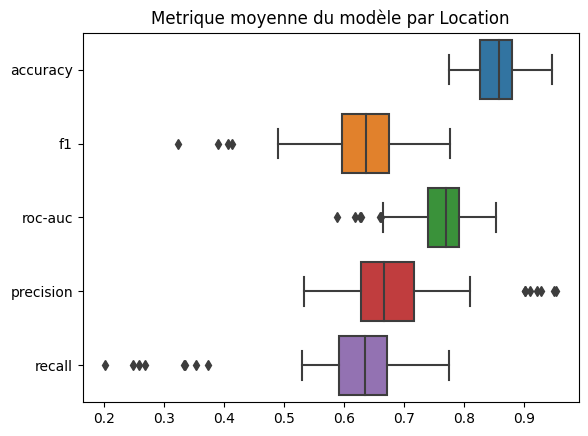

In [39]:
sns.boxplot(data = df_global, orient = 'h')
plt.title('Metrique moyenne du modèle par Location')
plt.show()

In [ ]:
df_global.median(axis = 0)